In [5]:
import numpy as np
import os
import uvicorn
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from utils import count_letters, print_line, read_inputs, score

In [6]:
class Tokeniser:
    """
    A class for encoding and decoding strings into tokens for model input.

    Attributes
    ----------
    length : int
        Expected length of input strings. Defaults to 20.
    char_to_id : dict
        Dictionary mapping characters to their corresponding token IDs.
    id_to_char : dict
        Dictionary mapping token IDs to their corresponding characters.

    Methods
    -------
    encode(string: str) -> torch.Tensor
        Encodes a string into a tensor of token IDs.
    
    decode(tokens: torch.Tensor) -> str
        Decodes a tensor of token IDs into a string.
    """
    def __init__(self, length: int = 20):
        """
        Initialises the tokeniser, defining the vocabulary.

        Parameters
        ----------
        length : int, optional
            Expected length of input strings. Defaults to 20.
        """
        self.length = length
        
        vocab = [chr(ord('a') + i) for i in range(0, 26)] + [' '] # vocab of lowerchase chars and space

        self.char_to_id = {ch: i for i, ch in enumerate(vocab)} # dictionary of character to token id
        self.id_to_char = {i: ch for i, ch in enumerate(vocab)} # dictionary of token id to character
    
    def encode(self, string: str) -> torch.Tensor:
        """
        Encodes a string into a tensor of token IDs.

        Parameters
        ----------
        string : str
            The input string to encode.
        
        Returns
        -------
        torch.Tensor (shape [self.length])
            A tensor containing the token IDs corresponding to input string.
            
        Raises
        ------
        ValueError
            If 'string' is not 'self.length' characters long.
            If 'string' contains out-of-vocabulary characters.
        """
        if len(string) != self.length: # ensure input string is correct length
            raise ValueError(f"Input string must be exactly {self.length} characters long, but got {len(string)} characters.")
        
        try:
            tokens_list = [self.char_to_id[c] for c in string] # convert string to tokens list
        except KeyError as e:
            raise ValueError(f"Out of vocabulary character encountered: '{e.args[0]}'")
        
        tokens_tensor = torch.tensor(tokens_list, dtype=torch.long) # convert token list into tensor
        return tokens_tensor
    
    def decode(self, tokens: torch.Tensor) -> str:
        """
        Decodes a tensor of token IDs into a string.

        Parameters
        ----------
        tokens : torch.Tensor
            A tensor containing token IDs to decode.
        
        Returns
        -------
        str
            A decoded string corresponding to input tokens.
        """
        return "".join([self.id_to_char[i.item()] for i in tokens])

In [7]:
train_inputs = read_inputs("../../data/train.txt")
test_inputs = read_inputs("../../data/test.txt")

10000 lines read
--------------------------------------------------------------------------------
1000 lines read
--------------------------------------------------------------------------------


In [12]:
def batch_tensor(tensor_list, batch_size) -> torch.Tensor:
    """
    Converts a list of 1D tensors into a batched 3D tensor. Used with 'process_dataset'.

    Parameters
    ----------
    tensor_list : list of torch.Tensor
        A list of 1D tensors to be batched together.
    batch_size : int
        The number of tensors to include in each batch.
    
    Returns
    -------
    torch.Tensor (shape [num_batches, batch_size, tensor_length])
        A 3D batched tensor, grouping each input tensor into groups of size 'batch_size'.
    """
    tensor_stacked = torch.stack(tensor_list) # convert list of 1D tensors to stacked 2D tensor
    
    num_batches = len(tensor_stacked) // batch_size # find whole number of batches (may trim last items)
    excess_items = len(tensor_stacked) % batch_size # calculate number of extra items which don't fit into batches
    if excess_items != 0:
        print(f"Trimming last {excess_items} items to ensure equal batch sizes.")
        tensor_stacked = tensor_stacked[:-excess_items] # trim tensor
    
    batched_tensor = tensor_stacked.view(num_batches, batch_size, -1) # reshape 2D tensor into batched 3D tensor
    return batched_tensor
    

def process_dataset(inputs, tokeniser, batch_size = 4) -> dict:
    """
    Processes raw data into input tokens and labels, creating a dataset dictionary of batched tensors.

    Parameters
    ----------
    inputs : list of str
        Train or test data examples split into a list.
    tokeniser : Tokeniser
        An instance of the Tokeniser class used to encode the input.
    batch_size : int, optional
        The number of items to include in each batch. Defaults to 4.

    Returns
    -------
    dict
        - 'input_ids' : torch.Tensor (shape [num_batches, batch_size, tensor_length])
            The batched tensor of tokenised input strings.
        - 'labels' : torch.Tensor (shape [num_batches, batch_size, tensor_length])
            The batched tensor of labels corresponding to input IDs.
    
    Raises
    ------
    ValueError
        If length of 'inputs' is less than 'batch_size'.
    """
    
    if len(inputs) < batch_size:
        raise ValueError("Input list is too short for a single batch.")

    input_ids_list = [tokeniser.encode(text) for text in inputs] # list of token tensors for each input
    labels_list = [count_letters(text) for text in inputs] # list of label tensors for each input

    # create dictionary of batched 3D input and label tensors
    dataset = {
        'input_ids': batch_tensor(input_ids_list, batch_size),
        'labels': batch_tensor(labels_list, batch_size)
    }
    print("Dataset created.", ", ".join([f"{key}: {tensor.size()}" for key, tensor in dataset.items()]))
    print_line()
    return dataset

In [13]:
class BERTEmbedding(nn.Module):
    """
    A class for a BERT Embedding layer which creates and combines token and position embeddings.

    Attributes
    ----------
    length : int
        Expected length of input strings. Defaults to 20.
    token_embedding : nn.Embedding
        Embedding layer which maps each token to a dense vector of size 'embed_dim'.
    position_embedding : nn.Embedding
        Embedding layer which maps each position index to a dense vector of size 'embed_dim'.
    dropout : nn.Dropout
        Dropout layer for regularisation.

    Methods
    -------
    forward(input_ids: torch.Tensor) -> torch.Tensor
        Performs a forward pass, computing the BERT embeddings used as model input for a given 'input_ids'.
    """
    def __init__(self, vocab_size: int, length: int, embed_dim: int, dropout: int):
        """
        Initialises the BERT Embedding.

        Parameters
        ----------
        vocab_size : int
            Total number of unique tokens.
        length : int
            Expected length of input strings.
        embed_dim : int
            Dimensionality of the token and position embeddings.
        dropout : int
            Dropout probability, used for regularisation.
        """
        super().__init__() # initialise the nn.Module parent class
        self.length = length # store the sequence length

        self.token_embedding = nn.Embedding(vocab_size, embed_dim) # map each token to a dense vector of size embed_dim
        self.position_embedding = nn.Embedding(length, embed_dim) # map each position index to a dense vector of size embed_dim
        self.dropout = nn.Dropout(dropout) # dropout layer for regularisation

    def forward(self, input_ids: torch.Tensor) -> torch.Tensor:
        """
        Performs a forward pass, computing the BERT embeddings used as model input for a given 'input_ids'.

        Parameters
        ----------
        input_ids : torch.Tensor (shape [batch_size, length])
            The tensor containing token indices for the input sequences of a given batch.

        Returns
        -------
        torch.Tensor  (shape [batch_size, length, embed_dim])
            The tensor containing the BERT embeddings for the input sequences of a given batch.
        """
        device = input_ids.device # used to ensure all tensors are on same device

        token_embedding = self.token_embedding(input_ids) # look up token embeddings for each token in input_ids

        position_input = torch.arange(self.length, device=device).unsqueeze(0) # create position indices for each token
        position_embedding = self.position_embedding(position_input) # look up position embeddings for each position index in input_ids
        
        embedding = token_embedding + position_embedding # BERT embedding is element-wise sum of token embeddings and position embeddings
        embedding = self.dropout(embedding) # apply dropout for regularisation
        return embedding

In [14]:
class BERT(nn.Module):
    """
    A class for a BERT model, used to classify the cumulative frequencies of the respective character of every 'input_ids' item.

    Attributes
    ----------
    embedding : BERTEmbedding
        Embedding layer which combines token and position embeddings.
    encoder_block : nn.TransformerEncoder
        Transformer Encoder.
    classifier : nn.Linear
        Output layer, predicting classes 0, 1, 2 for cumulative character frequency for each position in sequence

    Methods
    -------
    forward(input_ids: torch.Tensor) -> torch.Tensor
        Performs a forward pass, computing the logits for each class of each item of 'input_ids'.
    """
    def __init__(self, vocab_size: int = 27, length: int = 20, embed_dim: int = 768, dropout: int = 0.1, attention_heads: int = 12, layers: int = 2):
        """
        Initialises the BERT Model.

        Parameters
        ----------
        vocab_size : int, optional
            Total number of unique tokens. Defaults to 27.
        length : int, optional
            Expected length of input strings. Defaults to 20.
        embed_dim : int, optional
            Dimensionality of the token and position embeddings. Defaults to 768.
        dropout : int, optional
            Dropout probability, used for regularisation. Defaults to 0.1.
        attention_heads : int, optional
            The number of attention heads in the Transformer encoder layer. Defaults to 12.
        layers : int, optional
            The number of Transformer encoder layers. Defaults to 2.
        """
        super().__init__()  # initialise the nn.Module parent class
        
        self.embedding = BERTEmbedding(vocab_size, length, embed_dim, dropout) # embedding layer which combines token and position embeddings
        encoder_layer = nn.TransformerEncoderLayer(embed_dim, attention_heads, dim_feedforward=embed_dim * 4, dropout=dropout, activation="gelu") # instance of transformer encoder layer
        self.encoder_block = nn.TransformerEncoder(encoder_layer, layers) # full transformer encoder consisting of multiple layers

        self.classifier = nn.Linear(embed_dim, 3) # output layer, predicting classes 0, 1, 2 for each position in sequence

    def forward(self, input_ids: torch.Tensor):
        """
        Performs a forward pass, computing the logits for each class of each item of 'input_ids'.

        Parameters
        ----------
        input_ids : torch.Tensor (shape [batch_size, length])
            The tensor containing token indices for the input sequences of a given batch.

        Returns
        -------
        torch.Tensor  (shape [batch_size, length, 3 (classes)])
            The tensor containing the class logits for each item of the input sequences of a given batch.
        """
        embeddings = self.embedding(input_ids) # get embeddings for each token in input_ids
        embeddings = embeddings.transpose(0, 1) # rearrange embeddings from [batch_size, length, embed_dim] to [length, batch_size, embed_dim] for encoder block

        encoder_output = self.encoder_block(embeddings) # pass embeddings through transformer encoder block

        logits = self.classifier(encoder_output.transpose(0, 1)) # apply classifier to each position to get logits for each class
        return logits

In [15]:
model = BERT()
dataset_train = process_dataset(train_inputs, tokeniser)
dataset_test = process_dataset(test_inputs, tokeniser)

C:\Users\mrozi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Dataset created. input_ids: torch.Size([2500, 4, 20]), labels: torch.Size([2500, 4, 20])
--------------------------------------------------------------------------------
Dataset created. input_ids: torch.Size([250, 4, 20]), labels: torch.Size([250, 4, 20])
--------------------------------------------------------------------------------


In [16]:
def evaluate(model : BERT, dataset_test: dict, loss_fn: nn.CrossEntropyLoss) -> float:
    model.eval()  # set model to evaluation mode
    batches = len(dataset_test['input_ids']) # number of batches in the test dataset
    loss_total = 0
    with torch.no_grad():  # disable gradient calculation
        for batch in range(batches):
            
            logits = model(dataset_test['input_ids'][batch]) # forward pass to compute logits
            logits = logits.view(-1, logits.size(-1)) # flatten batch dimension: [batch_size * length, classes]
            labels = dataset_test['labels'][batch].view(-1) # flatten batch dimension: [batch_size * length]

            loss_batch = loss_fn(logits, labels) # calculate loss between output logits and labels
            loss_total += loss_batch.item()

    loss_average = loss_total / batches # loss is the average of all batches
    print(f'eval loss: {round(loss_average,2)}')
    model.train() # revert model to training mode
    return loss_average

In [43]:
def plot_train(plot_data: dict):
    fig, axs = plt.subplots(len(plot_data.keys()), 1, figsize=(8, 6), sharex=True) # create subplots

    for p,plot in enumerate(plot_data.keys()): # plot x,y of each subplot in plot_data
        axs[p].plot(plot_data[plot]['x'],plot_data[plot]['y'])
        axs[p].set_title(plot)
    
    plt.tight_layout()
    plt.show()

In [36]:
def train_classifier(dataset_train: dict, dataset_test: dict, learning_rate: float = 1e-6, epochs: int = 1, eval_every: int = 250) -> BERT:
    """
    Creates and trains a BERT model for cumulative frequency classification given a training dataset.

    Parameters
    ----------
    dataset_train : dict
        A dictionary containing the inputs and labels of the training data.
        - 'input_ids' : torch.Tensor (shape [num_batches, batch_size, tensor_length])
            The batched tensor of tokenised input strings.
        - 'labels' : torch.Tensor (shape [num_batches, batch_size, tensor_length])
            The batched tensor of labels corresponding to input IDs.
    dataset_train : dict
        A dictionary containing the inputs and labels of the test data.
        Refer to 'dataset_train'.
    learning_rate : float, optional
        The learning rate for the optimiser (magnitiude of weight updates per step). Defaults to 1e-6.
    epochs : int, optional
        The number of epochs for training. Each epoch corresponds to one full iteration through training data. Defaults to 1.

    Returns
    -------
    BERT
        The trained BERT model.
    """
    plot_data = {'train':{'x':[],'y':[]}, 'test':{'x':[],'y':[]}} # dict storing x,y plot data for training progress

    model = BERT() # initialise model
    model.train() # set model to training mode

    optimiser = torch.optim.AdamW(model.parameters(), lr=learning_rate) # initialise AdamW optimiser
    loss_fn = nn.CrossEntropyLoss() # initialise cross-entropy loss function for classification

    batches = len(dataset_train['input_ids']) # number of batches in the training dataset
    for epoch in range(epochs): # iterate through epochs
        for batch in range(batches): # iterate through batches in epoch
            
            if batch%eval_every == 0: # perform evaluation on test split at set intervals
                loss_test = evaluate(model, dataset_test, loss_fn)
                plot_data['test']['x'].append(batch)
                plot_data['test']['y'].append(loss_test)

            logits = model(dataset_train['input_ids'][batch]) # forward pass to compute logits
            logits = logits.view(-1, logits.size(-1)) # flatten batch dimension: [batch_size * length, classes]
            labels = dataset_train['labels'][batch].view(-1) # flatten batch dimension: [batch_size * length]
            
            loss = loss_fn(logits, labels) # calculate loss between output logits and labels
            
            optimiser.zero_grad() # zero the gradients from previous step (no gradient accumulation)
            loss.backward() # backpropagate to compute gradients
            optimiser.step() # update model weights

            plot_data['train']['x'].append(batch)
            plot_data['train']['y'].append(loss.item())
            print(f'step: {batch*(epoch+1)}/{batches*epochs} loss: {round(loss.item(),2)}')
    
    plot_train(plot_data)
    return model

In [37]:
model = train_classifier(dataset_train, dataset_test)

C:\Users\mrozi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


eval loss: 1.19
step: 0/2500 loss: 1.05
step: 1/2500 loss: 1.33
step: 2/2500 loss: 1.15
step: 3/2500 loss: 1.17
step: 4/2500 loss: 1.11
step: 5/2500 loss: 1.22
step: 6/2500 loss: 1.12
step: 7/2500 loss: 1.15
step: 8/2500 loss: 1.15
step: 9/2500 loss: 1.17
step: 10/2500 loss: 1.11
step: 11/2500 loss: 1.15
step: 12/2500 loss: 1.11
step: 13/2500 loss: 1.18
step: 14/2500 loss: 0.99
step: 15/2500 loss: 1.21
step: 16/2500 loss: 1.11
step: 17/2500 loss: 1.05
step: 18/2500 loss: 1.17
step: 19/2500 loss: 1.15
step: 20/2500 loss: 1.05
step: 21/2500 loss: 1.05
step: 22/2500 loss: 1.12
step: 23/2500 loss: 1.15
step: 24/2500 loss: 1.02
step: 25/2500 loss: 1.1
step: 26/2500 loss: 1.08
step: 27/2500 loss: 1.04
step: 28/2500 loss: 1.07
step: 29/2500 loss: 1.11
step: 30/2500 loss: 1.08
step: 31/2500 loss: 1.03
step: 32/2500 loss: 1.11
step: 33/2500 loss: 1.03
step: 34/2500 loss: 1.13
step: 35/2500 loss: 1.05
step: 36/2500 loss: 1.09
step: 37/2500 loss: 1.09
step: 38/2500 loss: 1.02
step: 39/2500 loss: 

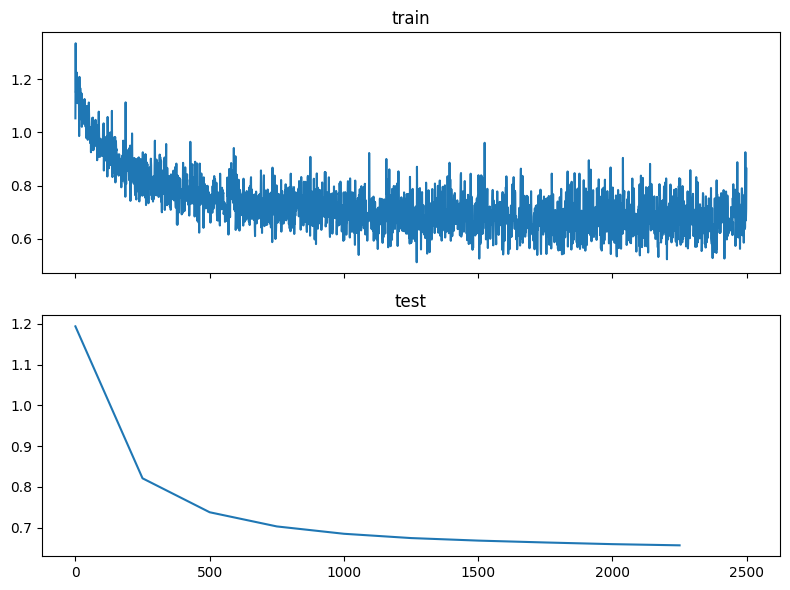

In [44]:
plot_train(plot_data)

In [94]:
predictions_list = []
for batch in dataset_test['input_ids']:
    logits = model(batch)
    prediction = torch.argmax(logits, dim=-1)
    predictions_list.append(prediction)

In [95]:
predictions_stacked = torch.stack(predictions_list)
predictions = predictions_stacked.view(1000, 20)

In [98]:
labels = dataset_test['labels'].view(1000, 20)

In [103]:
accuracy = torch.sum(labels == predictions).float() / labels.numel()

In [105]:
accuracy.item()*100

67.98999905586243